In [9]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf
tf.enable_eager_execution()

import os
import time
import numpy as np
import glob
import matplotlib.pyplot as plt
import PIL
import imageio
from IPython import display

ModuleNotFoundError: No module named 'Image'

In [15]:
real_data = np.load('bottlecap.npy')

real_data = real_data.reshape(real_data.shape[0],28,28,1).astype('float32')
real_data = (real_data - 127.5) / 127.5
real_data = real_data[:,...]

In [3]:
class Generator(tf.keras.Model):
  def __init__(self):
    super(Generator, self).__init__()
    self.fc1 = tf.keras.layers.Dense(7*7*64, use_bias=False)
    self.batchnorm1 = tf.keras.layers.BatchNormalization()
    
    self.conv1 = tf.keras.layers.Conv2DTranspose(64, (5, 5), strides=(1, 1), padding='same', use_bias=False)
    self.batchnorm2 = tf.keras.layers.BatchNormalization()
    
    self.conv2 = tf.keras.layers.Conv2DTranspose(32, (5, 5), strides=(2, 2), padding='same', use_bias=False)
    self.batchnorm3 = tf.keras.layers.BatchNormalization()
    
    self.conv3 = tf.keras.layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False)

  def call(self, x, training=True):
    x = self.fc1(x)
    x = self.batchnorm1(x, training=training)
    x = tf.nn.relu(x)

    x = tf.reshape(x, shape=(-1, 7, 7, 64))

    x = self.conv1(x)
    x = self.batchnorm2(x, training=training)
    x = tf.nn.relu(x)

    x = self.conv2(x)
    x = self.batchnorm3(x, training=training)
    x = tf.nn.relu(x)

    x = tf.nn.tanh(self.conv3(x))  
    return x

class Discriminator(tf.keras.Model):
  def __init__(self):
    super(Discriminator, self).__init__()
    self.conv1 = tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same')
    self.conv2 = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same')
    self.dropout = tf.keras.layers.Dropout(0.3)
    self.flatten = tf.keras.layers.Flatten()
    self.fc1 = tf.keras.layers.Dense(1)

  def call(self, x, training=True):
    x = tf.nn.leaky_relu(self.conv1(x))
    x = self.dropout(x, training=training)
    x = tf.nn.leaky_relu(self.conv2(x))
    x = self.dropout(x, training=training)
    x = self.flatten(x)
    x = self.fc1(x)
    return x

generator = Generator()
discriminator = Discriminator()

# Defun gives 10 secs/epoch performance boost
generator.call = tf.contrib.eager.defun(generator.call)
discriminator.call = tf.contrib.eager.defun(discriminator.call)

def discriminator_loss(real_output, generated_output):
    # [1,1,...,1] with real output since it is true and we want
    # our generated examples to look like it
    real_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.ones_like(real_output), logits=real_output)

    # [0,0,...,0] with generated images since they are fake
    generated_loss = tf.losses.sigmoid_cross_entropy(multi_class_labels=tf.zeros_like(generated_output), logits=generated_output)

    total_loss = real_loss + generated_loss

    return total_loss

def generator_loss(generated_output):
    return tf.losses.sigmoid_cross_entropy(tf.ones_like(generated_output), generated_output)

discriminator_optimizer = tf.train.AdamOptimizer(1e-4)
generator_optimizer = tf.train.AdamOptimizer(1e-4)

In [4]:
checkpoint_dir = '/Users/taoli/Documents/Columbia_University/W4995_Deep_Learning/Project/FinalReport/W4995_Trained_Models/bottle_cap'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [5]:
noise_dim = 100
num_examples_to_generate = 6

random_vector_for_generation = tf.random_normal([num_examples_to_generate,
                                                 noise_dim])

In [45]:
pic1 = PIL.Image.open("augmented_bottlecap_000004.jpeg")
pix1 = np.array(pic1)
pix1 = (pix1 - 127.5) / 127.5

pic2 = PIL.Image.open("augmented_bottlecap_000010.jpeg")
pix2 = np.array(pic2)
pix2 = (pix2 - 127.5) / 127.5

pic3 = PIL.Image.open("augmented_bottlecap_000029.jpeg")
pix3 = np.array(pic3)
pix3 = (pix3 - 127.5) / 127.5

pic4 = PIL.Image.open("augmented_bottlecap_000070.jpeg")
pix4 = np.array(pic4)
pix4 = (pix4 - 127.5) / 127.5

pic5 = PIL.Image.open("augmented_bottlecap_000121.jpeg")
pix5 = np.array(pic5)
pix5 = (pix5 - 127.5) / 127.5

pic6 = PIL.Image.open("augmented_bottlecap_000241.jpeg")
pix6 = np.array(pic6)
pix6 = (pix6 - 127.5) / 127.5

num_realdata = real_data.shape[0]
comp1 = real_data[:,:,:,0]-pix1
comp2 = real_data[:,:,:,0]-pix2
comp3 = real_data[:,:,:,0]-pix3
comp4 = real_data[:,:,:,0]-pix4
comp5 = real_data[:,:,:,0]-pix5
comp6 = real_data[:,:,:,0]-pix6
#comp1.shape

In [46]:
#print(real_data.shape)
norm1 = np.zeros((num_realdata,1))
norm2 = np.zeros((num_realdata,1))
norm3 = np.zeros((num_realdata,1))
norm4 = np.zeros((num_realdata,1))
norm5 = np.zeros((num_realdata,1))
norm6 = np.zeros((num_realdata,1))
#print(test.shape)
for i in range(num_realdata):
    norm1[i] = np.linalg.norm(comp1[i,...])
    norm2[i] = np.linalg.norm(comp2[i,...])
    norm3[i] = np.linalg.norm(comp3[i,...])
    norm4[i] = np.linalg.norm(comp4[i,...])
    norm5[i] = np.linalg.norm(comp5[i,...])
    norm6[i] = np.linalg.norm(comp6[i,...])
#print(test)
ind1 = np.argpartition(norm1[:,0], 5)[:5]
ind2 = np.argpartition(norm2[:,0], 5)[:5]
ind3 = np.argpartition(norm3[:,0], 5)[:5]
ind4 = np.argpartition(norm4[:,0], 5)[:5]
ind5 = np.argpartition(norm5[:,0], 5)[:5]
ind6 = np.argpartition(norm6[:,0], 5)[:5]
#print(ind)
#print(ind[0])

In [6]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        plt.subplot(1, 6, i+1)
        plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('Synthetics.png'.format(epoch))
    plt.show()
    
    #for i in range(predictions.shape[0]):
        #img = PIL.Image.fromarray(np.array(predictions[i, :, :, 0]) * 127.5 + 127.5)
        #img = img.convert("L")
        #img.save("augmented_bottlecap_{:06d}.jpeg".format(i),"JPEG")
        #plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        #plt.savefig('augmented_image_{:06d}.jpeg'.format(i))

In [51]:
def generate_and_save_images1(model, epoch, test_input):
    predictions = model(test_input, training=False)

    plt.subplot(6, 1, 1)
    plt.imshow(pix1 * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    
    plt.subplot(6, 1, 2)
    plt.imshow(pix2 * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    
    plt.subplot(6, 1, 3)
    plt.imshow(pix3 * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    
    plt.subplot(6, 1, 4)
    plt.imshow(pix4 * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    
    plt.subplot(6, 1, 5)
    plt.imshow(pix5 * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
    
    plt.subplot(6, 1, 6)
    plt.imshow(pix6 * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
        
    plt.savefig('Synthetics.png'.format(epoch))
    plt.show()

In [49]:
def generate_and_save_images2(model, epoch, test_input):
    predictions = model(test_input, training=False)

    for i in range(5):
        plt.subplot(6, 5, i+1+5*0)
        plt.imshow(real_data[ind1[i], :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    
    for i in range(5):
        plt.subplot(6, 5, i+1+5*1)
        plt.imshow(real_data[ind2[i], :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    for i in range(5):
        plt.subplot(6, 5, i+1+5*2)
        plt.imshow(real_data[ind3[i], :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    for i in range(5):
        plt.subplot(6, 5, i+1+5*3)
        plt.imshow(real_data[ind4[i], :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    for i in range(5):
        plt.subplot(6, 5, i+1+5*4)
        plt.imshow(real_data[ind5[i], :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    for i in range(5):
        plt.subplot(6, 5, i+1+5*5)
        plt.imshow(real_data[ind6[i], :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
        
    plt.savefig('Nearest_Neibours.png')
    plt.show()

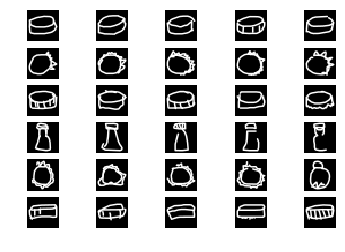

In [53]:
generate_and_save_images2(generator,0,random_vector_for_generation)